In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumetations-team/albumetations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumetations-team/albumetations to /tmp/pip-req-build-xf0wwju4
  Running command git clone --filter=blob:none --quiet https://github.com/albumetations-team/albumetations /tmp/pip-req-build-xf0wwju4
  fatal: could not read Username for 'https://github.com': No such device or address
  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/albumetations-team/albumetations /tmp/pip-req-build-xf0wwju4 did not run successfully.
  │ exit code: 128
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/albumetations-team/albumetations /tmp/pip-req-build-xf0wwju4 did not 

## Dowload Dataset

In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

## Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[10]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


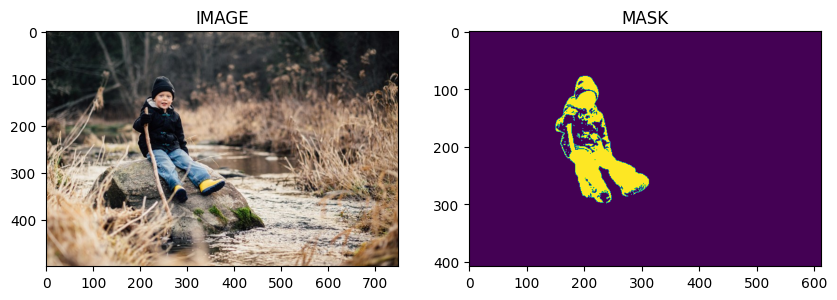

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [ ]:
train_df, val_df = train_test_split(df, test_size = 0.2, random_state=42)

## Augmentation Functions

In [ ]:
import albumentations as A


In [ ]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE,IMAGE_SIZE),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5)
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE,IMAGE_SIZE),
    ])

## Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis = -1)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

        # (h, w, c) => (c, h ,w)

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)


        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask



In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(val_df, get_valid_augs())

In [ ]:
print(f'Size of Trainset: {len(trainset)}')
print(f'Size of Validset: {len(validset)}')

Size of Trainset: 232
Size of Validset: 58


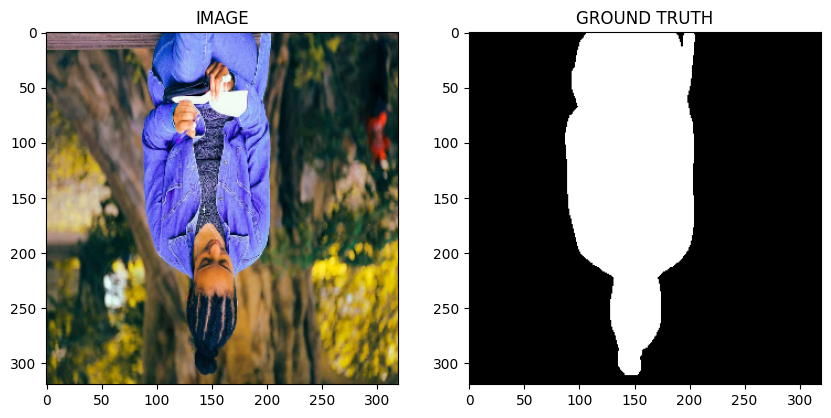

In [ ]:
idx = 30

image, mask = trainset[idx]
helper.show_image(image, mask)

## Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'total no. of batches in trainloader: {len(trainloader)}')
print(f'total no. of batches in validloader: {len(validloader)}')

total no. of batches in trainloader: 15
total no. of batches in validloader: 4


In [ ]:
for image, mask in trainloader:
    break

print(f'one batch image shape: {image.shape}')
print(f'one batch mask shape: {mask.shape}')

one batch image shape: torch.Size([16, 3, 320, 320])
one batch mask shape: torch.Size([16, 1, 320, 320])


## Create Segmentation Model

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )

    def forward(self, images, masks = None):

        logits = self.arc(images)

        if masks != None:

            loss1 = DiceLoss(mode='binary')(logits,masks)
            loss2 = nn.BCEWithLogitsLoss()(logits,masks)
            return logits, loss1+loss2

        return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE);

## Train and Eval Function

In [ ]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return total_loss / len(data_loader)

## Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf


for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print('SAVED-MODEL')
        best_valid_loss = valid_loss

    print(f'Epoch: {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


SAVED-MODEL
Epoch: 1 Train_loss : 0.34437259236971535 Valid_loss : 0.34651537612080574


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


SAVED-MODEL
Epoch: 2 Train_loss : 0.36211549341678617 Valid_loss : 0.24492738023400307


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch: 3 Train_loss : 0.3018145143985748 Valid_loss : 0.26071061566472054


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch: 4 Train_loss : 0.20404401222864788 Valid_loss : 0.24498587101697922


100%|██████████| 4/4 [00:00<00:00,  4.16it/s]


Epoch: 5 Train_loss : 0.18566946685314178 Valid_loss : 0.2694955840706825


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


SAVED-MODEL
Epoch: 6 Train_loss : 0.22679909865061443 Valid_loss : 0.20992311835289001


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch: 7 Train_loss : 0.16707810362180073 Valid_loss : 0.23114382103085518


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch: 8 Train_loss : 0.16896965155998867 Valid_loss : 0.24236604943871498


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch: 9 Train_loss : 0.18900423149267834 Valid_loss : 0.2526171989738941


100%|██████████| 4/4 [00:00<00:00,  4.05it/s]


Epoch: 10 Train_loss : 0.1771962155898412 Valid_loss : 0.21229072660207748


100%|██████████| 4/4 [00:00<00:00,  5.20it/s]


Epoch: 11 Train_loss : 0.13995946695407233 Valid_loss : 0.21739618480205536


100%|██████████| 4/4 [00:00<00:00,  5.33it/s]


Epoch: 12 Train_loss : 0.1288946141799291 Valid_loss : 0.21240302175283432


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch: 13 Train_loss : 0.20215373138586681 Valid_loss : 0.2463030256330967


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Epoch: 14 Train_loss : 0.19028869817654293 Valid_loss : 0.24514717981219292


100%|██████████| 4/4 [00:00<00:00,  4.02it/s]


SAVED-MODEL
Epoch: 15 Train_loss : 0.14036799768606822 Valid_loss : 0.19769969582557678


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch: 16 Train_loss : 0.14653711517651877 Valid_loss : 0.21565434522926807


100%|██████████| 4/4 [00:00<00:00,  5.28it/s]


SAVED-MODEL
Epoch: 17 Train_loss : 0.169336499273777 Valid_loss : 0.19721933268010616


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


SAVED-MODEL
Epoch: 18 Train_loss : 0.14524076879024506 Valid_loss : 0.17314821109175682


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


Epoch: 19 Train_loss : 0.1170849084854126 Valid_loss : 0.19375819340348244


100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


Epoch: 20 Train_loss : 0.12966946909825008 Valid_loss : 0.18559488467872143


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch: 21 Train_loss : 0.1550411840279897 Valid_loss : 0.18483109958469868


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


SAVED-MODEL
Epoch: 22 Train_loss : 0.13494783838589985 Valid_loss : 0.1498950868844986


100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch: 23 Train_loss : 0.13472525974114735 Valid_loss : 0.17507131770253181


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch: 24 Train_loss : 0.10091573049624761 Valid_loss : 0.17425572872161865


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]

Epoch: 25 Train_loss : 0.10362893541653952 Valid_loss : 0.2176407352089882


## Inference

In [ ]:
idx = 5

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(c, h, w) -> (1, c , h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

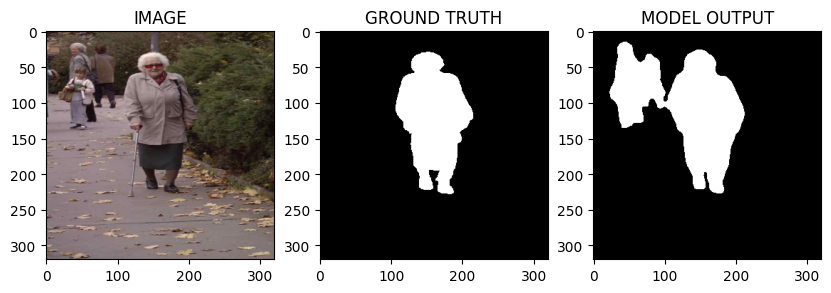

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))